# SpaceNet U-Net

This notebook is orginal from Boggis30 named 'SpaceNetUnet'. URL: https://github.com/boggis30/SpaceNetUnet
I added some comments to better understand the code 

### Summary of  the Notebook: 
This code executes building detection with the help of an U-Net-like architecture. 
By additionally reducing the final layer, the models' accuracy increases (improved model). 

Model: 
- Conv2D; (Batch Normalization); ReLu; double convolution possible
- Maxpooling 

- UNetUp: Conv2DTranspose + Concatenate

- final_reduce = False: Conv2D
- final_reduce = True: Conv2D, Lambda(reduce_layer)

Lastly, explore the filters with Hyperopt ---> best results?!

Thought and ideas on improving the code or comparing with other applications: 



# Imports

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K


import glob
import os
import re
import datetime

from PIL import Image


import numpy as np
import pandas as pd

from sklearn.metrics import multilabel_confusion_matrix


from hyperopt import hp
from hyperopt import fmin, pyll, tpe, hp, STATUS_OK, Trials

import pickle
import time

import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D

# Data Generators

Generate Data to feed the UNet with !

In [4]:
# add here the folder path, where your SpaceNet data is stored
directory = 'E:/W_Katrin/AOI_2_Vegas/AOI_2_Vegas_Train/tiles'


files = glob.glob(os.path.join(directory,'*'))

pattern_img = '.*\.jpg'
# create a list of all images in that directory [after converting them to jpg with the code in Github README]
files_img = list(filter(re.compile(pattern_img).match,files))

pattern_mask = '.*\.tif'
# create a list of all labeled/classified images [therefore masks]
files_mask = list(filter(re.compile(pattern_mask).match,files))

files_mask = sorted(files_mask)
files_img = sorted(files_img)

print(' All files: {}\n'.format(len(files)),
      'Image files: {}\n'.format(len(files_img)),
      'Mask files: {}'.format(len(files_mask)))

 All files: 7704
 Image files: 3852
 Mask files: 3852


In [5]:
# create a dataframe of the satellite images and their respective mask 
df_files = pd.DataFrame(columns=['img','mask'])
df_files['img'] = files_img
df_files['mask'] = files_mask

# return a random sample [frac defines how big of a fraction of the original data the sampled data should be; 1 means equal]
df_files = df_files.sample(frac=1,random_state=10)


train_bound = int(len(df_files) * 0.7)
val_bound = int(len(df_files) * 0.85)

# define 70% of the data as trainings data and 15% for validation and 15% for testing
df_train = df_files.iloc[:train_bound]
df_val = df_files.iloc[train_bound:val_bound]
df_test = df_files.iloc[val_bound:]

print(' Train examples: {}\n'.format(len(df_train)),
      'Validation examples: {}\n'.format(len(df_val)),
      'Test examples: {}\n'.format(len(df_test)))

 Train examples: 2696
 Validation examples: 578
 Test examples: 578




Image and respective mask examples

Found 10 validated image filenames.
Found 10 validated image filenames.


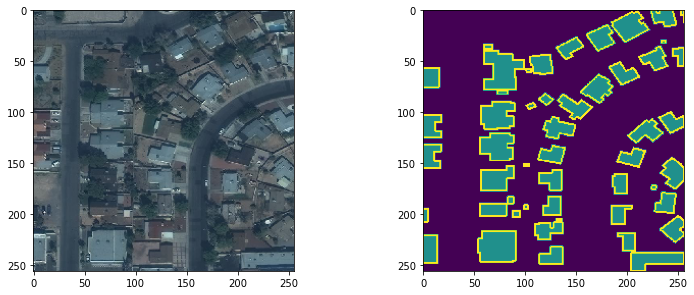

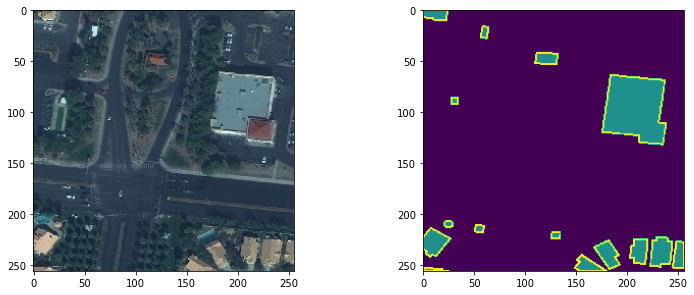

In [6]:
def make_tuple_gen(df_files,target_size,batch_size,seed):# this function generates augmented data[!not only training data!]
    # or better said: it generates a function which generates augmented data[generator function]
    
    # https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
    # generate batches of tensor image data with real-time data augmentation 
    # batches of original training data are randomly transformed and then used for training (not the original data!)
  img_gen = keras.preprocessing.image.ImageDataGenerator()
    
    # read data from dataframe and perform powerful on-the-fly image augmentation with ImageDataGenerator
  img_generator = img_gen.flow_from_dataframe(
          dataframe=df_files,        
          x_col='img',
          target_size=target_size,
          batch_size=batch_size,
          seed = seed,
          class_mode=None,
          color_mode='rgb')
  
  mask_gen = keras.preprocessing.image.ImageDataGenerator()

  mask_generator = mask_gen.flow_from_dataframe(
          dataframe=df_files,        
          x_col='mask',
          target_size=target_size,
          batch_size=batch_size,
          seed = seed,
          class_mode=None,
          color_mode='grayscale')


  return zip(img_generator, mask_generator)

def make_gen4unet(df_files,target_size = (256, 256),batch_size = 1, seed = 10):
  
  tuple_gen =  make_tuple_gen(df_files,target_size,batch_size,seed) # tuple_gen consists of two generators

  def _gen():  # loop through tuple_gen and for the mask layers: assign values [1,2] to y= [100,255]
    while True: 
      x,y = next(tuple_gen) # returns the next item in a generator, x = img_generator, y = mask_generator
      
      y[y==100] = 1
      y[y==255] = 2

      yield x,y

  return _gen()

print('\nImage and respective mask examples\n')
# This is only an example for display
genUnet = make_gen4unet(df_files.head(10)) # make generators only for 11 files to display
for i in range(2): #idk why they do that, maybe if looking at genUnet
  xx,yy = next(genUnet)
  xx = xx[0].astype(int)
  yy = np.squeeze(yy[0].astype(int)) #reduce by one axis


  plt.figure(figsize=1*np.array([2*6.4, 4.8]))
  plt.subplot(121)
  plt.imshow(xx)
  plt.subplot(122)
  plt.imshow(yy)
  plt.show()

In [7]:
train_gen = make_gen4unet(df_train,batch_size=30)
val_gen   = make_gen4unet(df_val,batch_size=30)
test_gen  = make_gen4unet(df_test,batch_size=578) #why take a bigger batch size here? # 578 is the size of the dataset, means we do only have one batch here

E:\W_Katrin\miniconda3\envs\tue_dl2\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  warnings.warn(


Found 2695 validated image filenames.


E:\W_Katrin\miniconda3\envs\tue_dl2\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="mask". These filename(s) will be ignored.
  warnings.warn(


Found 2695 validated image filenames.
Found 578 validated image filenames.
Found 578 validated image filenames.
Found 578 validated image filenames.
Found 578 validated image filenames.


# Model

In [8]:
def reduce_layer(n_classes):
  """The idea of this layer is the following:
  Original Unet has final conv layer with three filters. 
  Each filter has to be able to distinguish target class on the final feature map.
  Each filter has capacity of only 65 parameters, which might be insufficient.
  Improved Unet has increased number of filters per class in final conv layer.
  There are three groups of filters as per each class. Filters corresponding to 
  one classes are summed in the final layer before activation. 
  """
  
  def _reduce_layer(x):

    n_channel = x.shape[-1] #take the number in last dimension/axis, corresponds with number of channels
        
    # n_channel must be divisible by n_classes
    assert n_channel % n_classes == 0 # % gives remainder of division, so if you divide n_channel by n_classes it should be 0
    # assert here means: check this condition and immediately trigger an error if the condition is false

    ch1 = int(n_channel/n_classes)
    ch2 = int(2*n_channel/n_classes)
    
    x1 = x[...,:ch1] #last dimension = n_channels/n_classes
    x2 = x[...,ch1:ch2] # last dimension ch1-ch2
    x3 = x[...,ch2:n_channel] 

    x1 = K.sum(x1,axis=-1) # sum of the values in a tensor, alongside the specified axis (axis = dimension)
    x2 = K.sum(x2,axis=-1) # here axis is e.g. (x,x,X), always the last one
    x3 = K.sum(x3,axis=-1)

    y = K.stack([x1,x2,x3],axis=-1) #Stacks a list of rank R tensors into a rank R+1 tensor

    return y

  return _reduce_layer

def conv_block(n_filter,batch_norm=True):

  def _conv_block(x):
  
    if batch_norm:
  
      x = keras.layers.Conv2D(n_filter, (3,3),padding='same')(x)
    #Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
      x = keras.layers.BatchNormalization()(x) 
      x = keras.layers.ReLU()(x)
    
    else:  
  
      x = keras.layers.Conv2D(n_filter, (3,3),padding='same')(x)    
      x = keras.layers.ReLU()(x)

    return x

  return _conv_block

def unetConv2(n_filter,double_conv=True,batch_norm=True): #decide if you want to do either singular or double conv
    # going down the U
  
  def _unetConv2(x):
    
    if double_conv:    
    
      x = conv_block(n_filter,batch_norm) (x)
      x = conv_block(n_filter,batch_norm) (x)    
    
    else:    
    
      x = conv_block(n_filter,batch_norm) (x)
    
    return x

  return _unetConv2

def unetUp(n_filter,deconv=True): # going up the U, deconvolution means decoding 

  def _unetUp(input1,input2):

    if deconv:

      input2 = keras.layers.Conv2DTranspose(n_filter,(2,2),(2,2))(input2) # convolutional operation, will also upsample but
    # key difference to UpSampling is that the model should learn what is the best upsampling for the job
          
    else:
      
      input2 = keras.layers.UpSampling2D(size=(2,2))(input2) # Simple upscaling of the image using nearest neighbour or bilinear upsampling. 

    x = keras.layers.Concatenate()([input1,input2])

    return x

  return _unetUp

def unetModel(n_classes = 3,image_shape = (256,256,3) ,feature_scale=1, deconv=True, 
                 in_channels=3, double_conv=True, batch_norm=True, 
                 final_reduce=True,final_reduce_n_channel=30):
  
  """final_reduce_n_channel must be devisible by n_classes"""

  filters = [32, 64, 128, 256, 512]
  filters = [x // feature_scale for x in filters]

  x = keras.layers.Input(image_shape)

  conv1 = unetConv2(filters[0],double_conv,batch_norm) (x)
  maxpool1 = keras.layers.MaxPool2D(pool_size = (2,2)) (conv1)

  conv2 = unetConv2(filters[1],double_conv,batch_norm) (maxpool1)
  maxpool2 = keras.layers.MaxPool2D(pool_size = (2,2)) (conv2)

  conv3 = unetConv2(filters[2],double_conv,batch_norm) (maxpool2)
  maxpool3 = keras.layers.MaxPool2D(pool_size = (2,2)) (conv3)

  conv4 = unetConv2(filters[3],double_conv,batch_norm) (maxpool3)
  maxpool4 = keras.layers.MaxPool2D(pool_size = (2,2)) (conv4)

  center = unetConv2(filters[4],double_conv,batch_norm) (maxpool4)

  up_concat4 = unetUp(filters[3],deconv) (conv4,center)
  up_concat3 = unetUp(filters[2],deconv) (conv3,up_concat4)
  up_concat2 = unetUp(filters[1],deconv) (conv2,up_concat3)
  up_concat1 = unetUp(filters[0],deconv) (conv1,up_concat2)
  

  if final_reduce:

    final = keras.layers.Conv2D(final_reduce_n_channel,(1,1)) (up_concat1) #first convolute to size 1,1
    final = keras.layers.Lambda(reduce_layer(n_classes)) (final) # call the function reduce_layer to be performed on the last layer

  else: # if we do not want to reduce the final layer, we only convolute

    final = keras.layers.Conv2D(n_classes,(1,1)) (up_concat1)

  final_softmax = keras.activations.softmax(final, axis=-1) # converts a vector of values to a probability distribution

  model  = keras.Model(x,final_softmax)  # instantiate (erzeugen) the model

  return model

# Baseline

## Baseline Training

In [9]:
model_base_line = unetModel(final_reduce=False) # NOTE: final_reduce = FALSE, no reduction layer

# compile params are the same for baseline and improved
model_base_line.compile(optimizer='adam',metrics = ['sparse_categorical_accuracy'],loss= 'sparse_categorical_crossentropy')

In [13]:
# keras visualization tool
import pydot
import graphviz
tf.keras.utils.plot_model(model_base_line)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [10]:
%%time
logdir = 'log_dir/base_line/0' #defines the path name of the director to which system execution lgs are to be output

os.makedirs(logdir,exist_ok=True) # make the directory, if already exists leaves unaltered


callbacks = [keras.callbacks.TensorBoard(log_dir=logdir,
                                        histogram_freq=1,
                                        update_freq = 'epoch',                                     
                                        write_graph=True
                                        )] # write TensorBoard logs after very batch of training [epoch]to monitor metrics
                                        

history_base_line = model_base_line.fit_generator(train_gen, # fit_generator will be deprecated, better use fit()
                              steps_per_epoch=25, # total number of steps (batches of samples) before declaring that one epoch finished
                              epochs=10,
                              verbose=1, # verbosity mode = progress bar 
                              validation_data=val_gen,
                              validation_steps=19,
                              callbacks=callbacks)

<timed exec>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
25/25 [==============================] - 390s 16s/step - loss: 0.5174 - sparse_categorical_accuracy: 0.7966 - val_loss: 2.2492 - val_sparse_categorical_accuracy: 0.2096
Epoch 2/10
25/25 [==============================] - 389s 16s/step - loss: 0.3793 - sparse_categorical_accuracy: 0.8594 - val_loss: 1.9316 - val_sparse_categorical_accuracy: 0.2964
Epoch 3/10
25/25 [==============================] - 389s 16s/step - loss: 0.3119 - sparse_categorical_accuracy: 0.8841 - val_loss: 0.8278 - val_sparse_categorical_accuracy: 0.6715
Epoch 4/10
25/25 [==============================] - 382s 15s/step - loss: 0.3102 - sparse_categorical_accuracy: 0.8870 - val_loss: 0.5369 - val_sparse_categorical_accuracy: 0.7891
Epoch 5/10
25/25 [==============================] - 403s 16s/step - loss: 0.2816 - sparse_categorical_accuracy: 0.8963 - val_loss: 0.3989 - val_sparse_categorical_accuracy: 0.8531
Epoch 6/10
25/25 [==============================] - 393s 16s/step - loss: 0.2612 - sparse_categorica

## Baseline Validation

In [14]:
def validate_image(img,mask,model):

    mask_pred = model.predict(img) # generates output predictions for the input samples.

    i=0
    img = img[i].astype(int)
    mask = np.squeeze(mask[i].astype(int)) # reduce by one axis
    mask_pred = np.squeeze(mask_pred[i]) # reduce again by one axis
    mask_pred_rend = np.argmax(mask_pred,axis=-1) # Returns the indices of the maximum values along an axis.

    plt.figure(figsize=0.8*np.array([4*6.4, 4.8]))
    plt.subplot(141) # = plt.subplot(1,4,1), 1 row, 4 columns,  first subplot (from right to left, first top row)
    plt.imshow(img)
    plt.subplot(142)
    plt.imshow(mask)
    plt.subplot(143)
    plt.imshow(mask_pred)
    plt.subplot(144)
    plt.imshow(mask_pred_rend)
    plt.show()
    
    return mask_pred, mask_pred_rend

def plot_history(history_dict): # I want two plots with almost the same params, so I make a function

  metrics = ['loss', 'sparse_categorical_accuracy'] # training metrics I want to plot (y-axis - names)
  val_metrics = ['val_los', 'val_sparse_categorical_accuracy'] # validation metrics 


  epochs = range(1, len(history_dict['loss']) + 1)

  plt.figure(figsize=0.8*np.array([6*6.4, 4.8]))
  
  for i,metric in enumerate(metrics): # enumerate: Loop over something and have an automatic counter 
    plt.subplot(141+i)    
    plt.plot(epochs, history_dict[metric], 'bo', label='Training ' + metric) # x-axis, y-axis, blue circle markers, label)
    plt.plot(epochs, history_dict['val_' + metric], 'b', label='Validation' + metric) # same as above but with validation, line
    plt.title('Training and validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()


  plt.show()

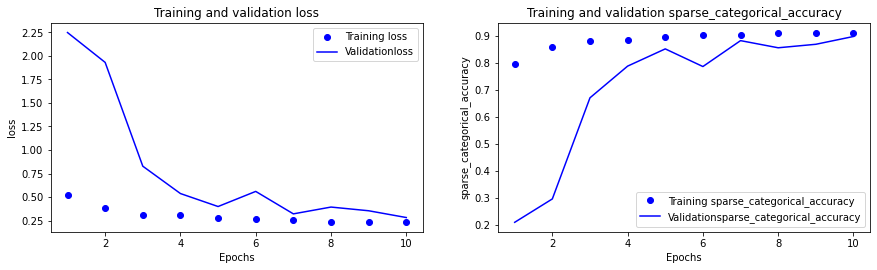

In [15]:
plot_history(history_base_line.history)

In [16]:
val_image_gen   = make_gen4unet(df_val,batch_size=1,seed=12) # make generator for validation images

img_val,mask_val = next(val_image_gen)

Found 578 validated image filenames.
Found 578 validated image filenames.


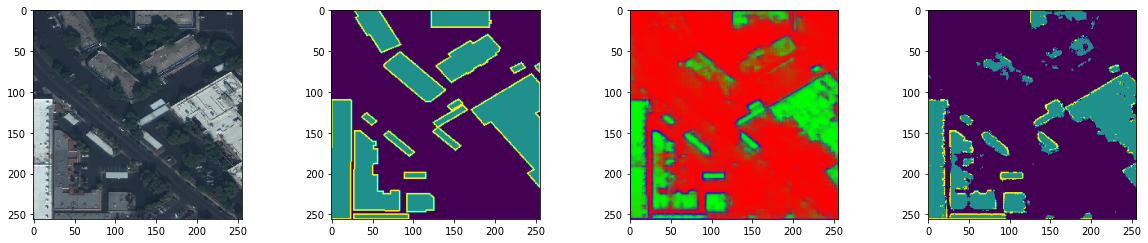

In [17]:
_ = validate_image(img_val,mask_val,model_base_line) # _ throwaway variable? 
# 1: img  2: mask  3: mask_prediction  4: mask_pred_rend (argmax, returns indices of max values along an axis)

## Baseline Model Analysis

<font size = '+1'>Here you can analyse model's tensors and see what is happing in the learning process.<br>
Cells below basically reproduce tensorboard tensor histogram visualization. Additionally histograms below are stored in the notebook. </font>

In [53]:
def get_event_file(log_dir): # this function gets the log-file from the prevoius set log-dir
  event_files = glob.glob(os.path.join(log_dir,'train','*v2'))
  return event_files[0] 

def get_events_of_tensor(event_file,tensor_name): # this functon generates a list of the events of the tensors

  events = [] # list of iterators to read event file
  for e in tf.compat.v1.train.summary_iterator(event_file): 
    # Returns a iterator for reading Event protocol buffers from an event file. 
    # You can use this function to read events written to an event file
    events.append(e)
    
  events_of_tensor = []
  
  for e in events: 
    if len(e.summary.value)>0:      
      if re.compile('.*{}$'.format(tensor_name)).match(e.summary.value[0].tag): # here the error/warning about deprecation  
        # RE = a regular expression specifies a set of strings taht matches it
        # .compile = Compile a regular expression pattern into a regular expression object, which can be used for matching using its match(), search() and other methods, described below.
        # . = This matches any character except a newline  
        # * = Causes the resulting RE to match 0 or more repetitions of the preceding RE
        # {m} = exactly m copies of the previous RE should be matched
        # $ = Matches the end of the string or just before the newline at the end of the string
        # .match = If zero or more characters at the beginning of string match this regular expression, return a corresponding match object.
        # .tag = ?
        events_of_tensor.append(e) # list of events 

  print('Found {} events of tensor {}'.format(len(events_of_tensor),tensor_name))

  return events_of_tensor

def get_coef_histogram(events_of_tensor): # this function defines the variable coef_hist with its' params

  coef_hist = []

  for e in events_of_tensor:
    print(e)
    bucket_limit = np.array(e.summary.value[0].histo.bucket_limit) #if here is an error look for histo # HERE IS THE ERROR, problem is that the bucket is empty!
    bucket = np.array(e.summary.value[0].histo.bucket)
    print(bucket)
    
    bucket_limit[-1] = bucket_limit[-2] + bucket_limit[-2] - bucket_limit[-3]
    
    bucket_limit,bucket = smooth_hist(bucket_limit,bucket) # this function gets defined later - error? 

    bucket_limit = np.insert(bucket_limit,0,bucket_limit[0] - bucket_limit[1]+bucket_limit[0]) # (arr,obj,input values)
    bucket = np.insert(bucket,0,0)
    
    coef_hist.append(np.stack([bucket_limit,bucket],axis=1))

  return np.stack(coef_hist)

def smooth_hist(bins,bins_val): # this function 

  bins = np.array(bins)
  bins_val = np.array(bins_val)

  min_bin = bins.min()
  max_bin = bins.max()

  new_bins = np.linspace(min_bin,max_bin,30)

  new_bins_val = []
  for i in range(len(new_bins)-1):
    
    new_bin_value = np.sum(bins_val[np.logical_and(new_bins[i]<bins,bins<=new_bins[i+1])])
    new_bins_val.append(new_bin_value)

  new_bins = new_bins[1:]
  

  return new_bins,np.array(new_bins_val)

def draw_coef_hist(coef_hist,ax): # this function sets the params to draw the coefficient histogram per epoch in a 3d graph

  epochs = len(coef_hist)

  zs = np.array(range(epochs))
  
  for i in zs:

    verts = coef_hist[i]

    poly = PolyCollection([verts], facecolors=(1.0,0.3,0), edgecolors = (0,0,0))

    #harcoded alpha increment
    poly.set_alpha(0.8-i*0.05)
    ax.add_collection3d(poly, zs=[zs[i]], zdir='y')  


  x_min = coef_hist[:,:,0].min()
  x_max = coef_hist[:,:,0].max()

  z_max = coef_hist[:,:,1].max()

  ax.set_xlabel('X') # X = value(coefficient)
  ax.set_xlim3d(x_min, x_max)
  ax.set_ylabel('EPOCH NUM') # Y = epochs
  ax.set_ylim3d(0, epochs)
  ax.set_zlabel('Z') # Z = number of observations
  ax.set_zlim3d(0, z_max)
  
  return

In [54]:
# Display the Coefficient Histogram (run the functions from above)

log_dir = 'log_dir/base_line/0'
event_file = get_event_file(log_dir)

fig = plt.figure(figsize=1.5*np.array([2*6.4, 2*4.8]))

tensor_name = 'conv2d_9/bias_0'
events_of_tensor = get_events_of_tensor(event_file,tensor_name)
coef_hist = get_coef_histogram(events_of_tensor)

ax1 = fig.add_subplot(2, 2, 1, projection='3d')
draw_coef_hist(coef_hist,ax1)
ax1.title.set_text(tensor_name)


tensor_name = 'conv2d_10/bias_0'
events_of_tensor = get_events_of_tensor(event_file,tensor_name)
coef_hist = get_coef_histogram(events_of_tensor) # HERE IS THE ERROR!

ax2 = fig.add_subplot(2, 2, 2, projection='3d')
draw_coef_hist(coef_hist,ax2)
ax2.title.set_text(tensor_name)



tensor_name = 'conv2d_9/kernel_0'
events_of_tensor = get_events_of_tensor(event_file,tensor_name)
coef_hist = get_coef_histogram(events_of_tensor)

ax1 = fig.add_subplot(2, 2, 3, projection='3d')
draw_coef_hist(coef_hist,ax1)
ax1.title.set_text(tensor_name)



tensor_name = 'conv2d_10/kernel_0'
events_of_tensor = get_events_of_tensor(event_file,tensor_name)
coef_hist = get_coef_histogram(events_of_tensor)

ax2 = fig.add_subplot(2, 2, 4, projection='3d')
draw_coef_hist(coef_hist,ax2)
ax2.title.set_text(tensor_name)

plt.show()

Found 10 events of tensor conv2d_9/bias_0
wall_time: 1644850428.057983
summary {
  value {
    tag: "conv2d_9/bias_0"
    tensor {
      dtype: DT_DOUBLE
      tensor_shape {
        dim {
          size: 30
        }
        dim {
          size: 3
        }
      }
      tensor_content: "\000\000\000 \t\177\304\276\336\335\335\035U+\303\276\000\000\000\000\000\000\360?\336\335\335\035U+\303\276\274\273\273\033\241\327\301\276\000\000\000\000\000\000\000\000\274\273\273\033\241\327\301\276\232\231\231\031\355\203\300\276\000\000\000\000\000\000\000\000\232\231\231\031\355\203\300\276\357\356\356.r`\276\276\000\000\000\000\000\000\000\000\357\356\356.r`\276\276\253\252\252*\n\271\273\276\000\000\000\000\000\000\360?\253\252\252*\n\271\273\276fff&\242\021\271\276\000\000\000\000\000\000\000\000fff&\242\021\271\276\"\"\"\":j\266\276\000\000\000\000\000\000\360?\"\"\"\":j\266\276\336\335\335\035\322\302\263\276\000\000\000\000\000\000\000\000\336\335\335\035\322\302\263\276\232\231\231\03

IndexError: index -2 is out of bounds for axis 0 with size 0

<Figure size 1382.4x1036.8 with 0 Axes>

# Improved Unet

## Improved Unet Training

In [ ]:
model_improved = unetModel(final_reduce=True, final_reduce_n_channel=30) 
# take the same model, but this time final_reduce = TRUE !

model_improved.compile(optimizer='adam',metrics = ['sparse_categorical_accuracy'],loss= 'sparse_categorical_crossentropy')

In [ ]:
%%time
logdir = 'log_dir/improved/0'

os.makedirs(logdir,exist_ok=True)


callbacks = [keras.callbacks.TensorBoard(log_dir=logdir,
                                        histogram_freq=1,
                                        update_freq = 'epoch',                                     
                                        write_graph=True
                                        )]
                                        

history_model_improved = model_improved.fit_generator(train_gen, 
                              steps_per_epoch=25, 
                              epochs=10,
                              verbose=1, 
                              validation_data=val_gen,
                              validation_steps=19,
                              callbacks=callbacks)

Epoch 1/10
25/25 [==============================] - 16s 655ms/step - loss: 0.6749 - sparse_categorical_accuracy: 0.7804 - val_loss: 11.7993 - val_sparse_categorical_accuracy: 0.1736
Epoch 2/10
25/25 [==============================] - 15s 584ms/step - loss: 0.4321 - sparse_categorical_accuracy: 0.8407 - val_loss: 4.1147 - val_sparse_categorical_accuracy: 0.2069
Epoch 3/10
25/25 [==============================] - 15s 586ms/step - loss: 0.3794 - sparse_categorical_accuracy: 0.8608 - val_loss: 1.2927 - val_sparse_categorical_accuracy: 0.5434
Epoch 4/10
25/25 [==============================] - 14s 572ms/step - loss: 0.3485 - sparse_categorical_accuracy: 0.8740 - val_loss: 0.9346 - val_sparse_categorical_accuracy: 0.6420
Epoch 5/10
25/25 [==============================] - 15s 582ms/step - loss: 0.3148 - sparse_categorical_accuracy: 0.8841 - val_loss: 0.4725 - val_sparse_categorical_accuracy: 0.8240
Epoch 6/10
25/25 [==============================] - 14s 577ms/step - loss: 0.3059 - sparse_cat

## Improved Unet Validation

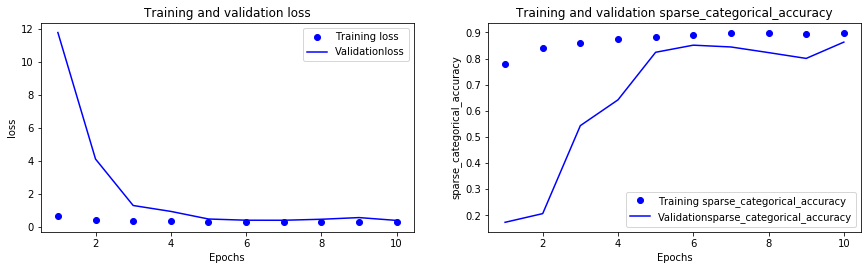

In [ ]:
plot_history(history_model_improved.history)

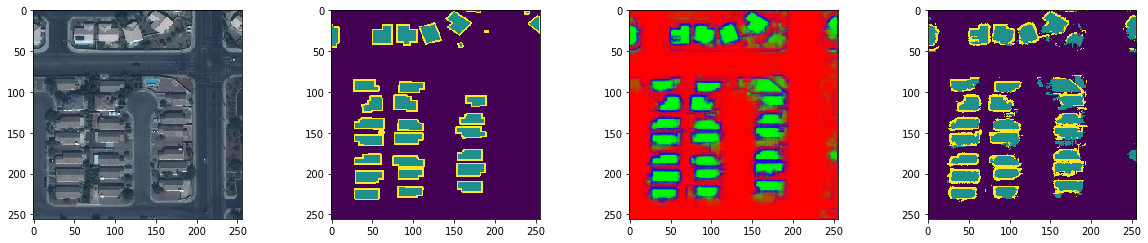

In [ ]:
_ = validate_image(img_val,mask_val,model_base_line)
# 1: img  2: mask  3: mask_prediction base_line_model  4: mask_pred_rend base_line_model 

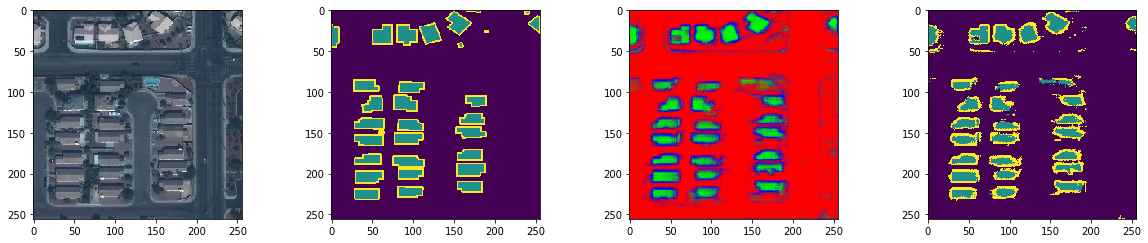

In [ ]:
_ = validate_image(img_val,mask_val,model_improved)
# 1: img  2: mask  3: mask_prediction improved_model  4: mask_pred_rend improved_model 

## Improved Unet Analysis

Found 10 events of tensor conv2d_20/bias_0
Found 10 events of tensor conv2d_21/bias_0
Found 10 events of tensor conv2d_20/kernel_0
Found 10 events of tensor conv2d_21/kernel_0


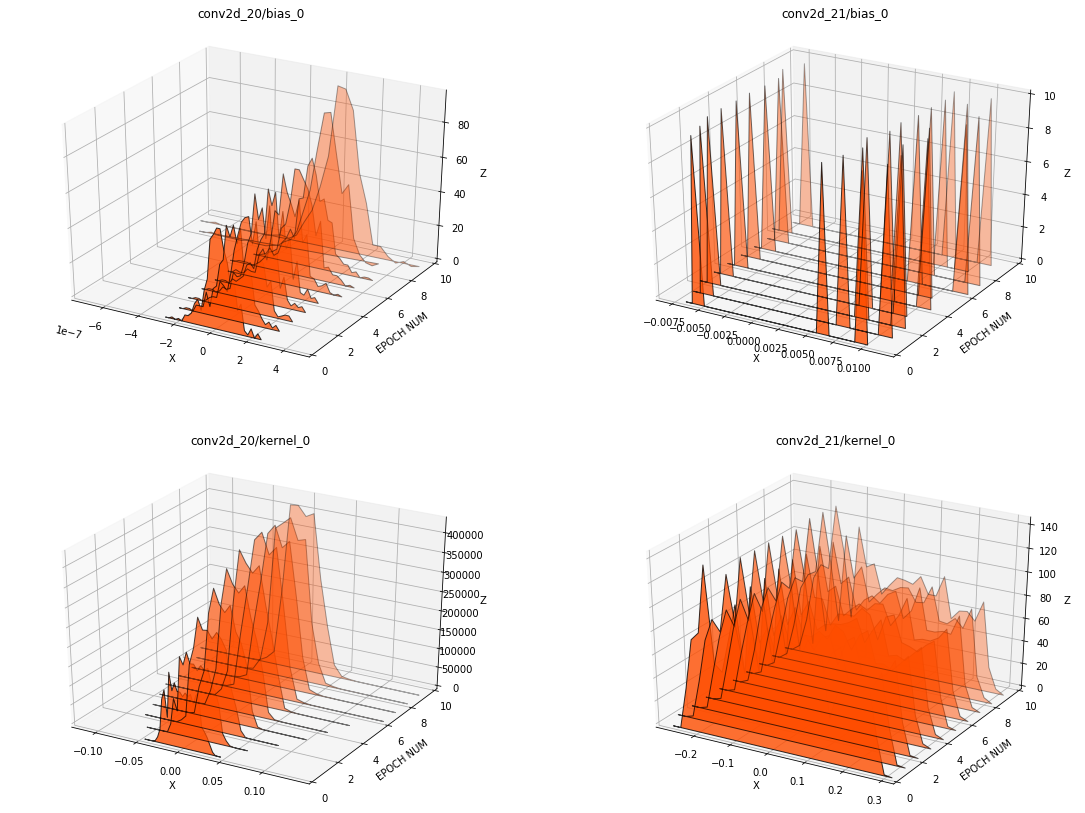

In [ ]:
log_dir = 'log_dir/improved/0'
event_file = get_event_file(log_dir)

fig = plt.figure(figsize=1.5*np.array([2*6.4, 2*4.8]))

tensor_name = 'conv2d_20/bias_0'
events_of_tensor = get_events_of_tensor(event_file,tensor_name)
coef_hist = get_coef_histogram(events_of_tensor)

ax1 = fig.add_subplot(2, 2, 1, projection='3d')
draw_coef_hist(coef_hist,ax1)
ax1.title.set_text(tensor_name)


tensor_name = 'conv2d_21/bias_0'
events_of_tensor = get_events_of_tensor(event_file,tensor_name)
coef_hist = get_coef_histogram(events_of_tensor)

ax2 = fig.add_subplot(2, 2, 2, projection='3d')
draw_coef_hist(coef_hist,ax2)
ax2.title.set_text(tensor_name)



tensor_name = 'conv2d_20/kernel_0'
events_of_tensor = get_events_of_tensor(event_file,tensor_name)
coef_hist = get_coef_histogram(events_of_tensor)

ax1 = fig.add_subplot(2, 2, 3, projection='3d')
draw_coef_hist(coef_hist,ax1)
ax1.title.set_text(tensor_name)



tensor_name = 'conv2d_21/kernel_0'
events_of_tensor = get_events_of_tensor(event_file,tensor_name)
coef_hist = get_coef_histogram(events_of_tensor)

ax2 = fig.add_subplot(2, 2, 4, projection='3d')
draw_coef_hist(coef_hist,ax2)
ax2.title.set_text(tensor_name)

plt.show()

<font size='+1'>It looks like models with higher number of filters per class in the final layer are less prone to overfit and perform better.<br>
Let's now explore how model's perfomance depends on the number of filters per class.</font>

## Exploration of filter number with Hyperopt
*Distributed Asynchronous Hyper-parameter Optimization*

Hyperopt's job is to find the best value of a scalar-valued, possibly-stochastic function over a set of possible arguments to that function. Whereas many optimization packages will assume that these inputs are drawn from a vector space, Hyperopt is different in that it encourages you to describe your search space in more detail. By providing more information about where your function is defined, and where you think the best values are, you allow algorithms in hyperopt to search more efficiently.

https://github.com/Vooban/Hyperopt-Keras-CNN-CIFAR-100/blob/master/IntroductionToHyperopt.ipynb

> *In other words, to use Hyperopt, I first needed to define an hyperparameter space, such as the range for which the learning rate can vary, the number of layers, the number of neurons in height, width and depth in the layers, how are the layers stacked, and on. Then running hyperopt takes time, but it proceeds to do what could be compared to using genetic algorithms to perform breeding and natural selection, except that there is no breeding here: just a readjustment from the past trials to try new trials in a way that balances exploration of new architectures versus optimization of the architecture near local maximas of performance. https://medium.com/vooban-ai/satellite-image-segmentation-a-workflow-with-u-net-7ff992b2a56e*

First time *pickle library* comes up: 
Pickle is used for serializing and de-serializing Python objects. This is a great way to store intermediate results while computing things.
    *dumps()* is how you pickle your data to a bytes sequence
    to use this in other languages. You can use *JSON* as encoder and decoder

In [ ]:
def objective(epochs=10,best_loss=10):

  best_loss = [best_loss]
  
  def _objective(final_reduce_n_channel):

    if not final_reduce_n_channel:
      model = unetModel(final_reduce=False)
    else:
      #round to the closes lower integer devisible by 3, 3 is the number of classes 
      # K: divide the number by 3 and then create a integer out of it (Ganzzahl, round down or up)
      final_reduce_n_channel = int((final_reduce_n_channel // 3) * 3)
      model = unetModel(final_reduce=True,final_reduce_n_channel=final_reduce_n_channel)

    model.compile(optimizer='adam',metrics = ['sparse_categorical_accuracy'],loss= 'sparse_categorical_crossentropy')

    history = model.fit_generator(train_gen, 
                                  steps_per_epoch=25, 
                                  epochs=epochs,
                                  verbose=0, 
                                  validation_data=val_gen,
                                  validation_steps=19)
    
    

    loss = history.history['val_loss'][-1]
    hst_dmp = pickle.dumps(history.history)

    if loss < best_loss[0]: # if loss smaller than best_loss; loss = best_loss and please get me the weights and json
      best_loss[0] = loss
      model_weights_dmp = pickle.dumps(model.get_weights())
      model_json_dmp = pickle.dumps(model.to_json())
    else:
      model_weights_dmp = None
      model_json_dmp = None

    #There is a chance that if model pointer persists, then memory leakage occur 
    del model
    del history

      
    return {
          'loss': loss,
          'status': STATUS_OK,
          'attachments':
              {'history' : hst_dmp,
               'model_weights' : model_weights_dmp,
               'model_json' : model_json_dmp}
          }
  
  return _objective

In [ ]:
space = hp.quniform('quniform', 3, 120,0.8) # defines the search space, in which fmin can search
# (label, low, high, q), returns a value like round(uniform(low,high)/q)*q

trials = Trials() # default database

best = fmin(objective(epochs=10), # objective adds special key-value pairs for optimizing the algorithm, loss function to minimize? 
    space=space,
    algo=tpe.suggest, # search algorithm, tree-structured Parzen Estimator
    max_evals=80,
    trials=trials) # by passing in a trials object directly, we can inspect all of the return values that were calculated during the experiment

print(best)

100%|██████████| 80/80 [3:08:29<00:00, 140.97s/it, best loss: 0.2411159363232161]
{'quniform': 59.2}


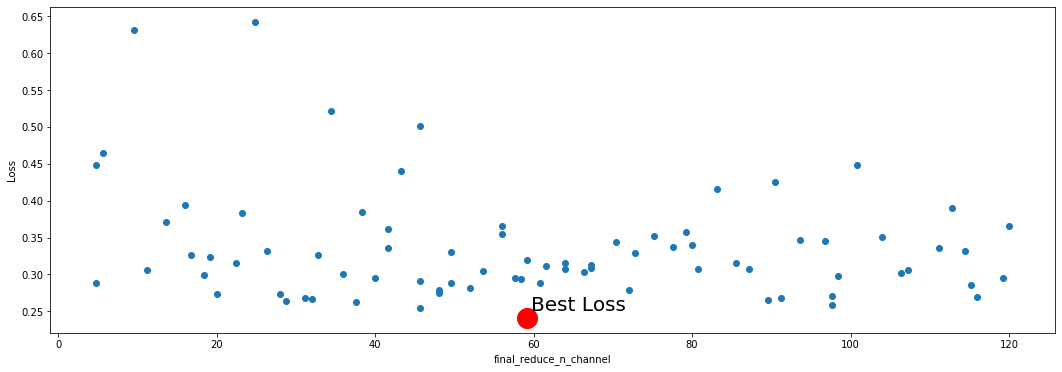

In [ ]:
n_chns = []
losses = []
for i in range(len(trials.trials)):
  n_chn = trials.trials[i]['misc']['vals']['quniform'] # trials.trials = list of dictionaries representing everything about the search
  if not n_chn:
    n_chn = [-1]

  n_chns.append(n_chn[0])
  losses.append(trials.trials[i]['result']['loss'])


plt.figure(figsize=(18,6))

best_loss_index = np.argmin(losses) # argmin returns indices of minimum value [which position in list!]
best_loss = losses[best_loss_index] # here: take indices of minium values as best loss = minimum loss
best_loss_nch = n_chns[best_loss_index]

plt.plot(best_loss_nch,best_loss,color='r', marker='o', markersize=20)
plt.text(best_loss_nch + 0.5, best_loss + .01, 'Best Loss', fontsize=20,color='k')

plt.scatter(n_chns, losses)
plt.xlabel('final_reduce_n_channel')
plt.ylabel('Loss')

plt.show()

In [ ]:
best_model_weights_dmp = trials.trial_attachments(trials.trials[best_loss_index])['model_weights']
best_model_weights = pickle.loads(best_model_weights_dmp)

best_model_json_dmp = trials.trial_attachments(trials.trials[best_loss_index])['model_json']
best_model_json = pickle.loads(best_model_json_dmp)

best_model = keras.models.model_from_json(best_model_json)
best_model.set_weights(best_model_weights)


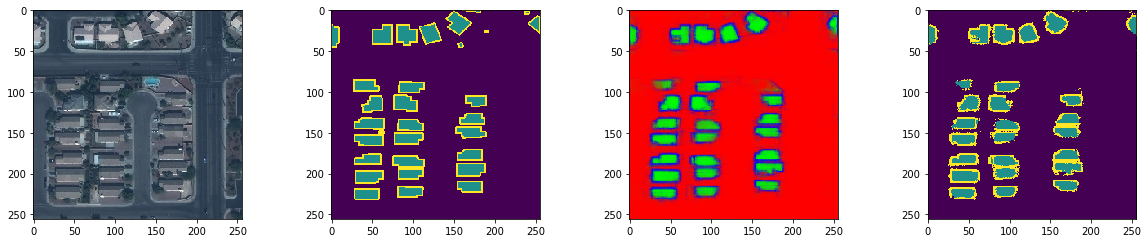

In [ ]:
_ = validate_image(img_val,mask_val,best_model)
# 1: img  2: mask  3: mask_prediction hyperopt model  4: mask_pred_rend hyperopt model

Base line output for comparison

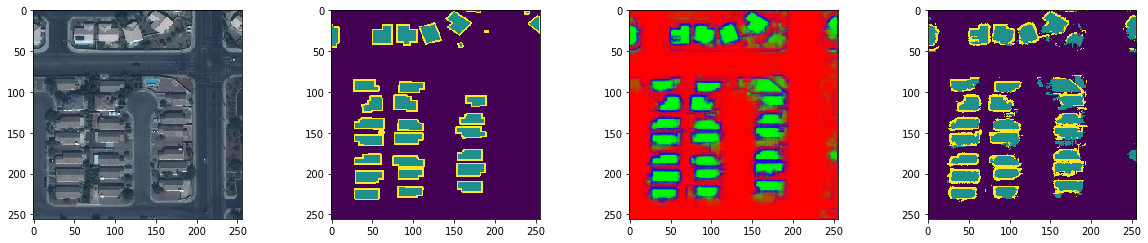

In [ ]:
_ = validate_image(img_val,mask_val,model_base_line)

# Test F1 all classes

precision = True Positive / (True Positive + False Positive) OR True Positive / Total predicted Positive

recall = True Positive / (True Positive + False Negative) OR  True Positive / Total actual Positive

f1 = 2x (precision x recall)/ (precision + recall)

In [ ]:
test_img,test_mask = next(test_gen)
test_mask = np.squeeze(test_mask)

test_mask_pred = best_model.predict(test_img)
test_mask_pred_rend = np.argmax(test_mask_pred,axis=-1)

cfm = multilabel_confusion_matrix(test_mask.flatten(),test_mask_pred_rend.flatten())

In [ ]:
for i in range(3):
  prec = cfm[i,1,1]/(cfm[i,1,1]+cfm[i,0,1]) 
  recall= cfm[i,1,1]/(cfm[i,1,1]+cfm[i,1,0])
  f1  = 2*prec*recall/(prec+recall)
  print('F1 score for class {} :'.format(i),f1) 
# I do not understand which class is what!

F1 score for class 0 : 0.9557618425516154
F1 score for class 1 : 0.8207834377347321
F1 score for class 2 : 0.4910952191472297


# TensorBoard

In [ ]:
#If you are running notebook in Google colab, Sometimes it is necessaty to run this cell twice to start tensorboard extension

%tensorboard --logdir log_dir/base_line/0

In [ ]:
#####stop tensorboard

!kill `ps aux|egrep tensorboard|grep -v grep|awk '{print $2}'`; echo "Stopping tensorboard res $?"